# **Stock Price Prediction Using ARIMA**

### Importing Libraries

In [215]:
!pip install pmdarima

In [216]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
from sklearn.metrics import r2_score
import pmdarima as pm

In [217]:
# Fix random seed for reproducibility
np.random.seed(1)
python_random.seed(1)

###Data Collection


In [218]:
# Download the historical stock price data for Apple
hist_data = yf.download('AAPL','2015-01-01','2019-12-31')
hist_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373951,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687307,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689541,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021715,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944687,237458000
...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908981,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342972,93121200


### Data Preprocessing

In [219]:
# Checking for missing values
print(hist_data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [220]:
# Filling missing dates
date_range = pd.date_range(start='2015-01-01', end='2019-12-30', freq='D')
hist_data = hist_data.reindex(date_range)
#hist_data.ffill(inplace=True)
hist_data_interpolated= hist_data.interpolate(method='linear')
hist_data_interpolated

,Open,High,Low,Close,Adj Close,Volume
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373951,2.128184e+08
2015-01-03,27.589167,27.627501,26.675833,27.075834,24.145070,2.275929e+08
2015-01-04,27.330833,27.395000,26.514167,26.819167,23.916189,2.423675e+08
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687307,2.571420e+08
...,...,...,...,...,...,...
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342972,9.312120e+07
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.316269,1.462660e+08
2019-12-28,72.641665,73.385834,71.788333,72.593330,70.455388,1.455488e+08
2019-12-29,72.503332,73.279167,71.546666,72.736664,70.594508,1.448316e+08


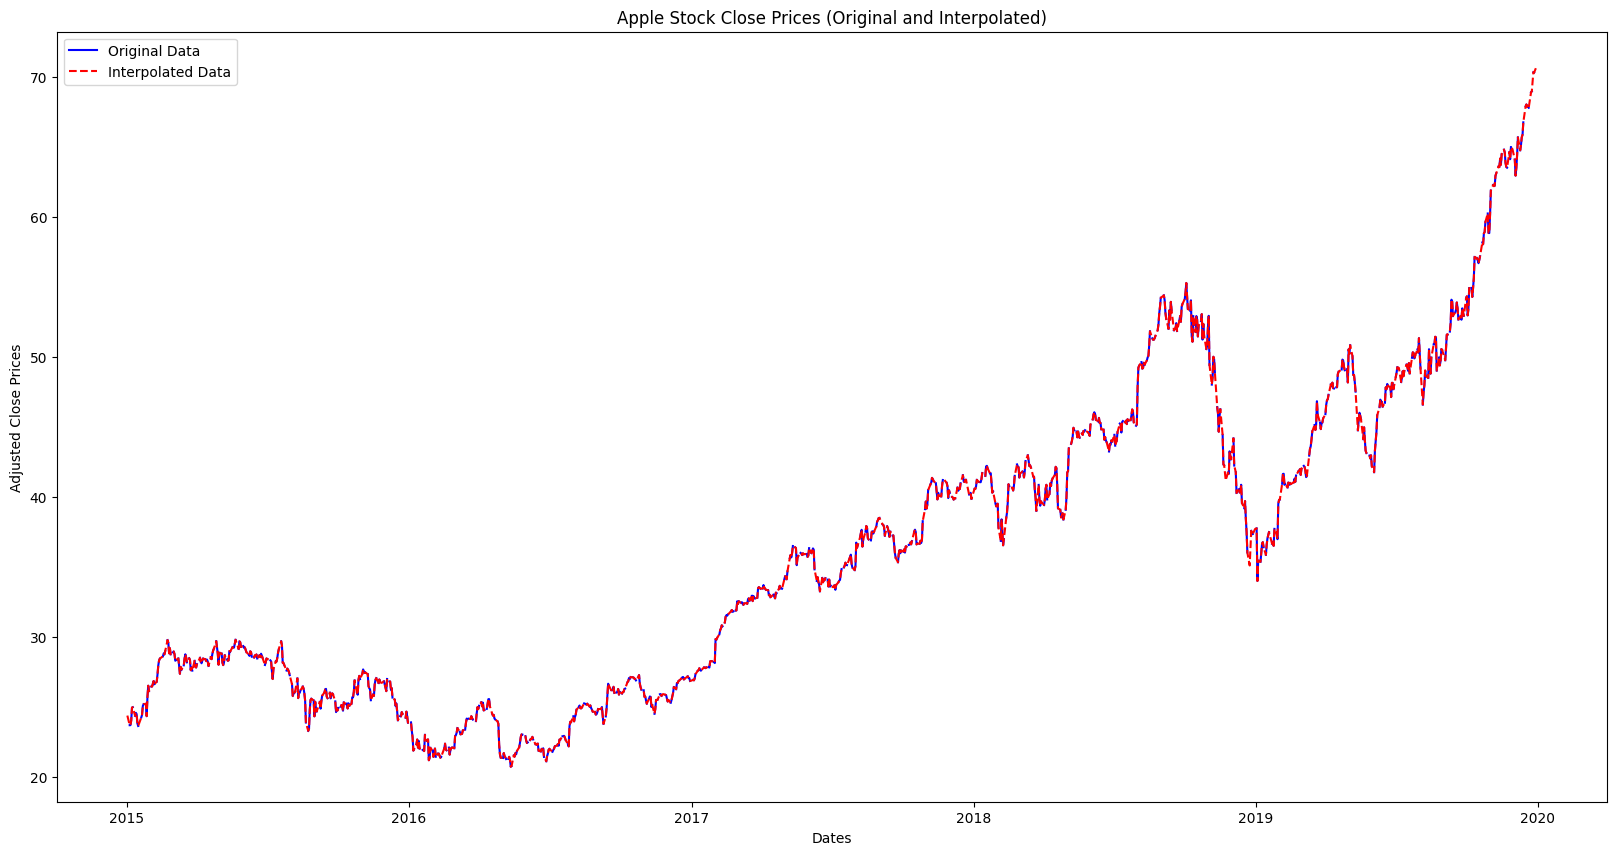

In [221]:
# Plot interpolated data
plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Adjusted Close Prices')
plt.title('Apple Stock Close Prices (Original and Interpolated)')
plt.plot(hist_data.index, hist_data['Adj Close'], label='Original Data', color='blue')
plt.plot(hist_data_interpolated.index, hist_data_interpolated['Adj Close'], label='Interpolated Data', color='red', linestyle='--')
plt.legend()
plt.show()

In [222]:
hist_data = hist_data_interpolated

### Exploratory Data Analysis

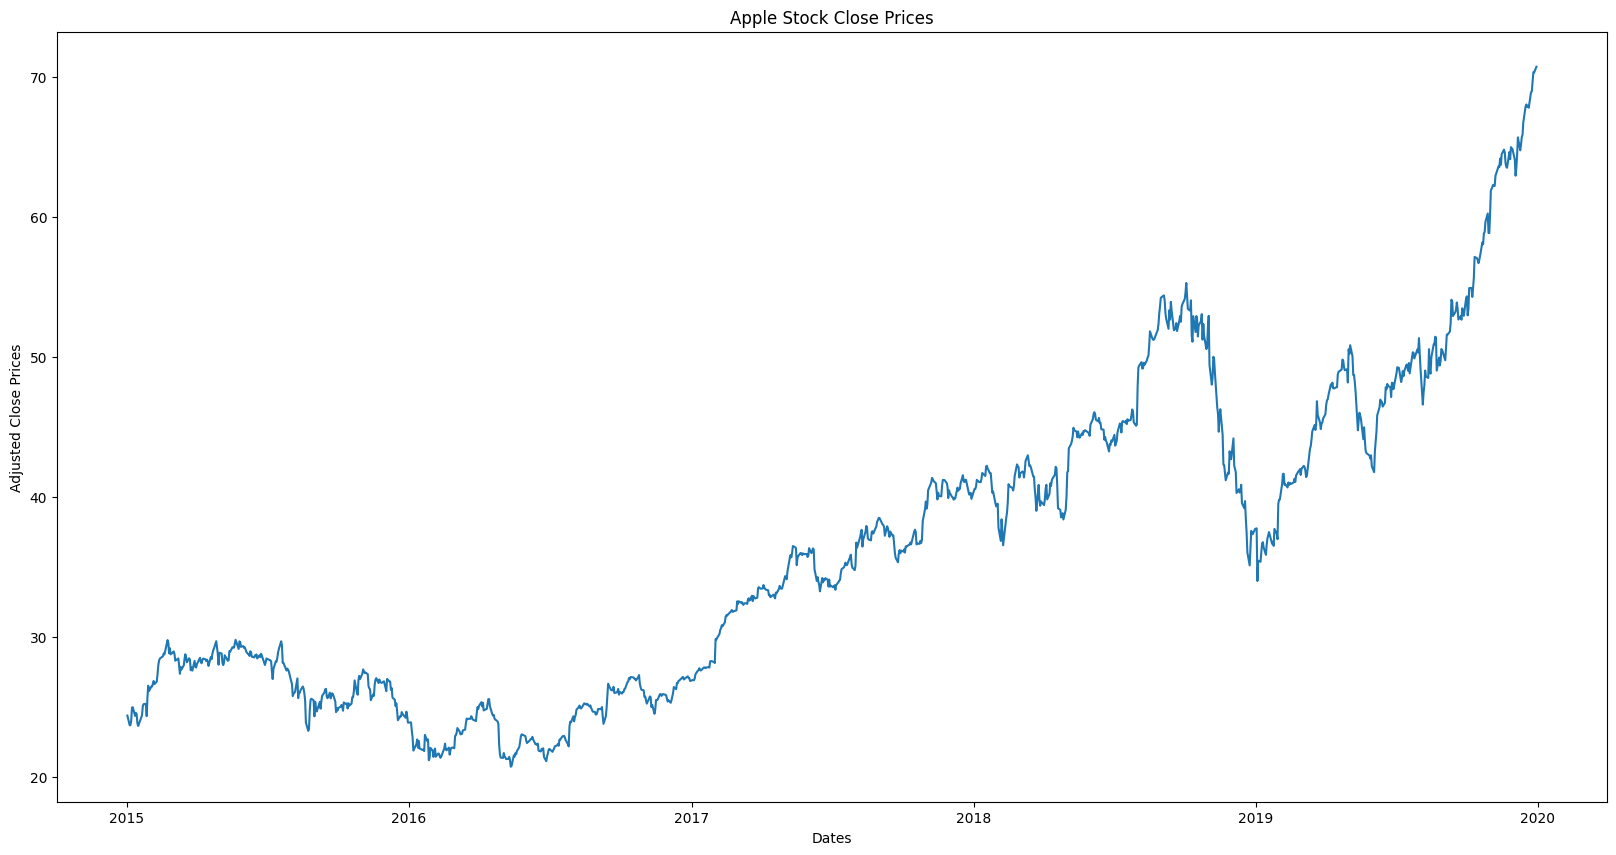

In [223]:
# Plot the historical stock data
plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Adjusted Close Prices')
plt.title('Apple Stock Close Prices')
plt.plot(hist_data['Adj Close'])
plt.show()

In [224]:
hist_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1.824000e+03
mean,38.550188,38.888459,38.220840,38.569967,36.215039,1.431543e+08
std,10.979875,11.078209,10.900476,11.004204,11.145274,6.892136e+07
min,22.500000,22.917500,22.367500,22.584999,20.720034,4.544800e+07
25%,28.910625,29.131875,28.626250,28.878749,26.312476,9.512950e+07
50%,37.522085,37.956251,37.188334,37.581250,35.375163,1.268771e+08
75%,46.309374,46.808959,45.956875,46.424376,44.191965,1.731278e+08
max,72.779999,73.492500,72.029999,72.879997,70.733627,6.488252e+08


In [225]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0, 1))
hist_data['Adj Close Scaled'] = scaler.fit_transform(hist_data['Adj Close'].values.reshape(-1, 1))

<Axes: ylabel='Density'>

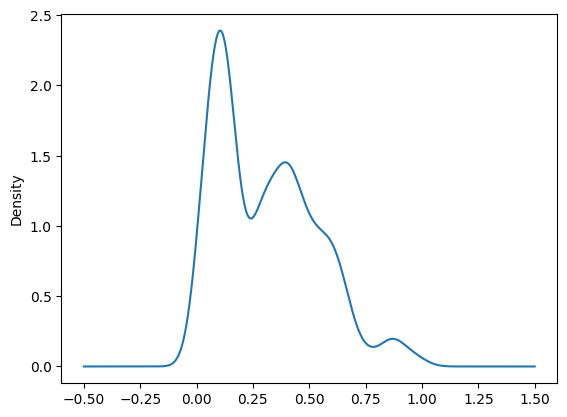

In [226]:
# Probability distribution of the dataset
hist_data_close = hist_data['Adj Close Scaled'].dropna()
hist_data_close.plot(kind='kde')

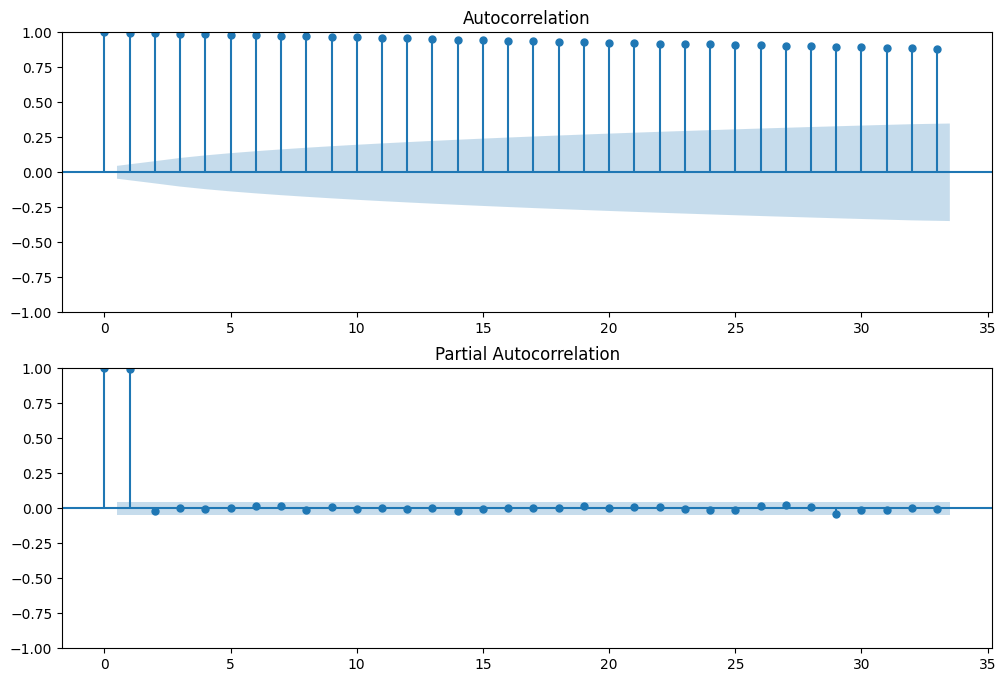

In [227]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(hist_data_close, ax=ax[0])
plot_pacf(hist_data_close, ax=ax[1])
plt.show()

### ADF Test for Stationarity

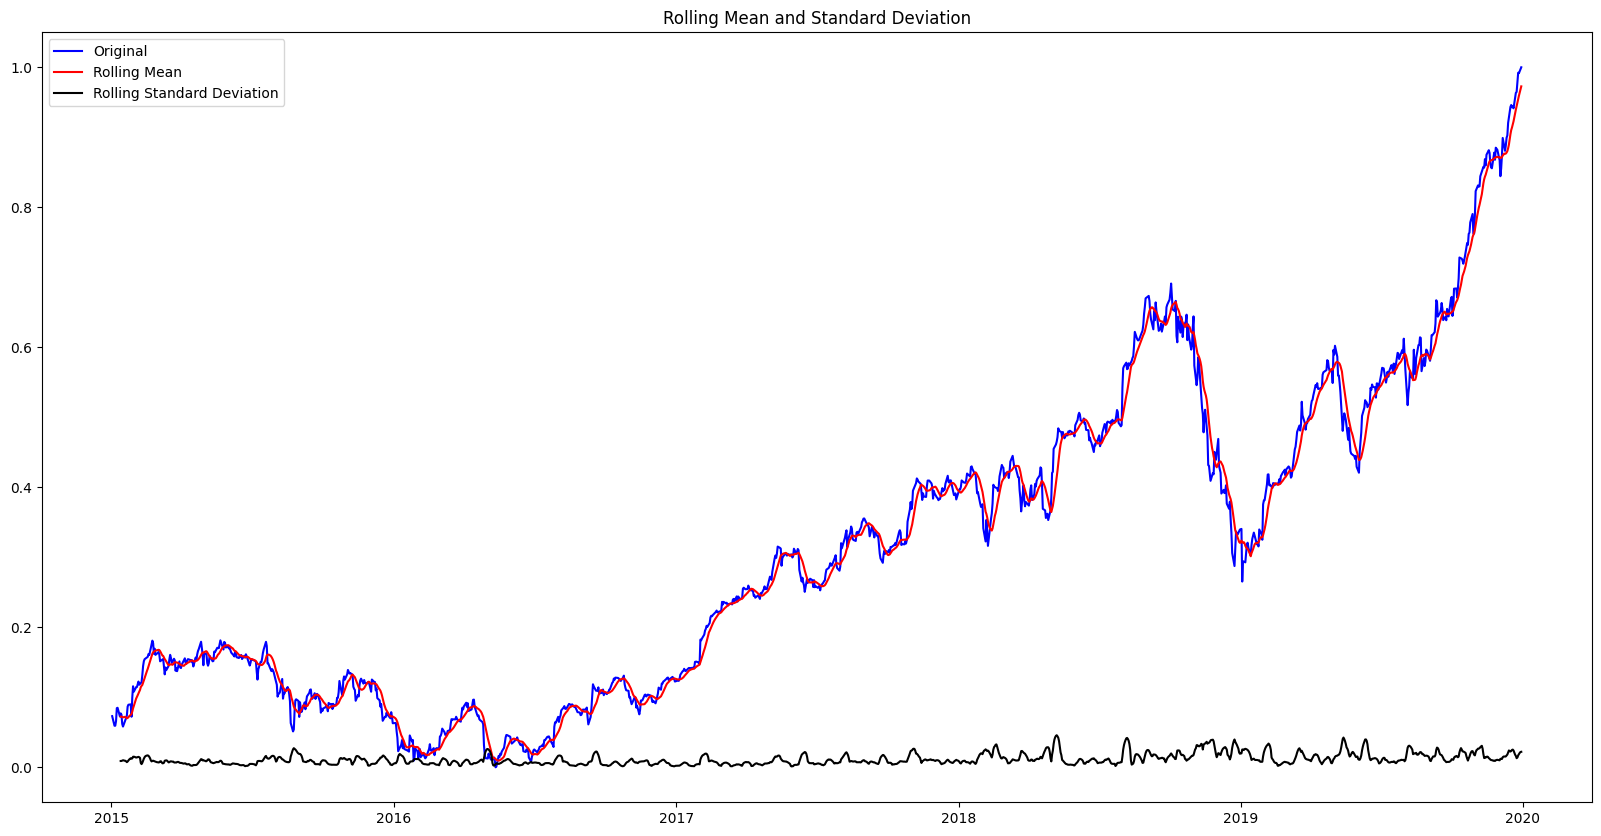

Results of Augmented Dickey Fuller test
Test Statistics                   1.385398
p-value                           0.997047
Number of lags used               1.000000
Number of observations used    1822.000000
Critical Value (1%)              -3.433944
Critical Value (5%)              -2.863128
Critical Value (10%)             -2.567615
dtype: float64


In [228]:
def test_stationarity(ts):
    rollmean = ts.rolling(12).mean()
    rollstd = ts.rolling(12).std()
    plt.figure(figsize=(20, 10))
    plt.title('Rolling Mean and Standard Deviation')
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rollmean, color='red', label='Rolling Mean')
    plt.plot(rollstd, color='black', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.show(block=False)
    print("Results of Augmented Dickey Fuller test")
    adft = adfuller(ts,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','Number of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['Critical Value (%s)'%key] =  values
    print(output)
test_stationarity(hist_data_close)

In [229]:
# First order differencing
hist_data['diff-1']= hist_data_close.diff(periods=1)
hist_data['diff-1']

,diff-1
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,-0.004576
2015-01-04,-0.004576
2015-01-05,-0.004576
...,...
2019-12-26,0.013681
2019-12-27,-0.000534
2019-12-28,0.002782
2019-12-29,0.002782


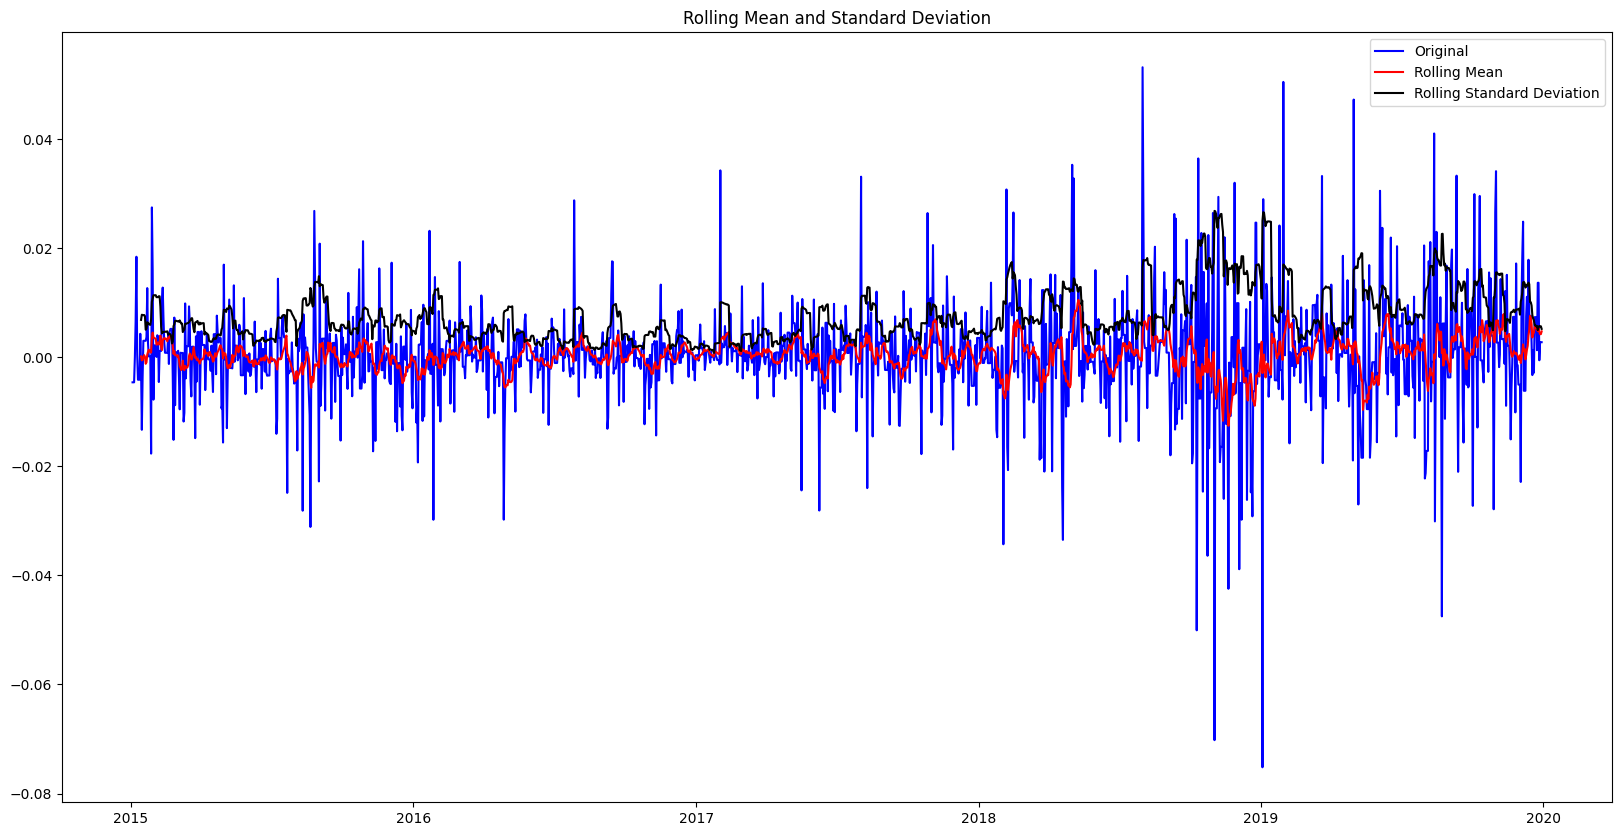

Results of Augmented Dickey Fuller test
Test Statistics                 -39.846761
p-value                           0.000000
Number of lags used               0.000000
Number of observations used    1822.000000
Critical Value (1%)              -3.433944
Critical Value (5%)              -2.863128
Critical Value (10%)             -2.567615
dtype: float64


In [230]:
# Perform ADF test on differenced data
hist_data_diff = hist_data['diff-1'].dropna()
test_stationarity(hist_data_diff)

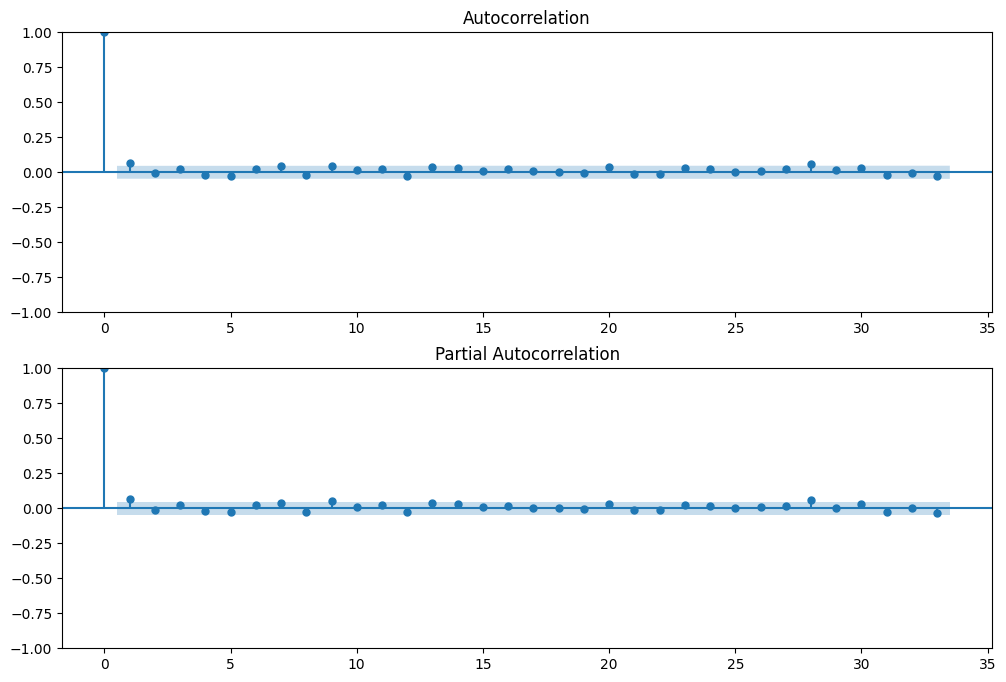

In [231]:
# Plot ACF and PACF for differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(hist_data_diff, ax=ax[0])
plot_pacf(hist_data_diff, ax=ax[1])
plt.show()

### Split data into training and testing set

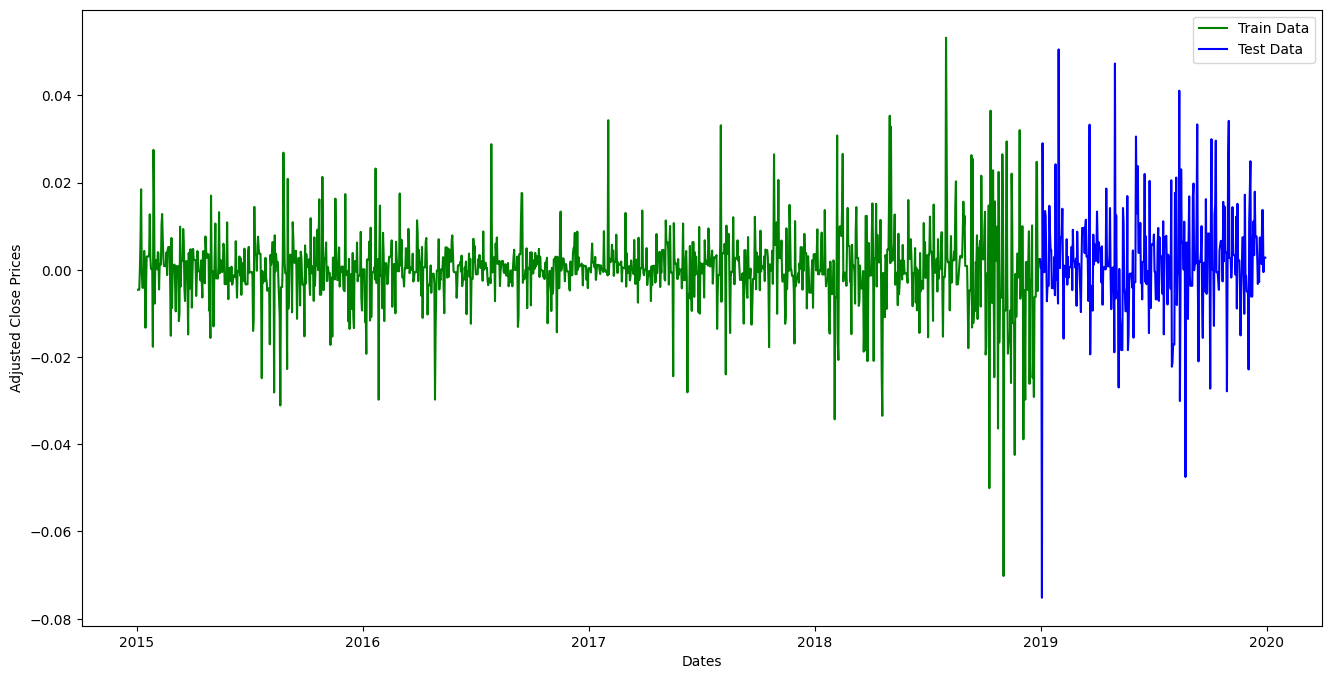

In [232]:
train_data, test_data = hist_data_diff[:int(len(hist_data_diff)*0.8)], hist_data_diff[int(len(hist_data_diff)*0.8):]
plt.figure(figsize=(16, 8))
plt.xlabel("Dates")
plt.ylabel("Adjusted Close Prices")
plt.plot(train_data, color ="green", label = "Train Data")
plt.plot(test_data, color="blue", label = "Test Data")
plt.legend(loc='best')
plt.show()

### Best Model Selection


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12018.798, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12016.574, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12023.843, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12024.002, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12022.185, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-12022.116, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12020.265, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-12027.155, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12020.458, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12025.471, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-12025.362, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-12026.958, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-12023.442, Time=0.63 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 4.746 seco

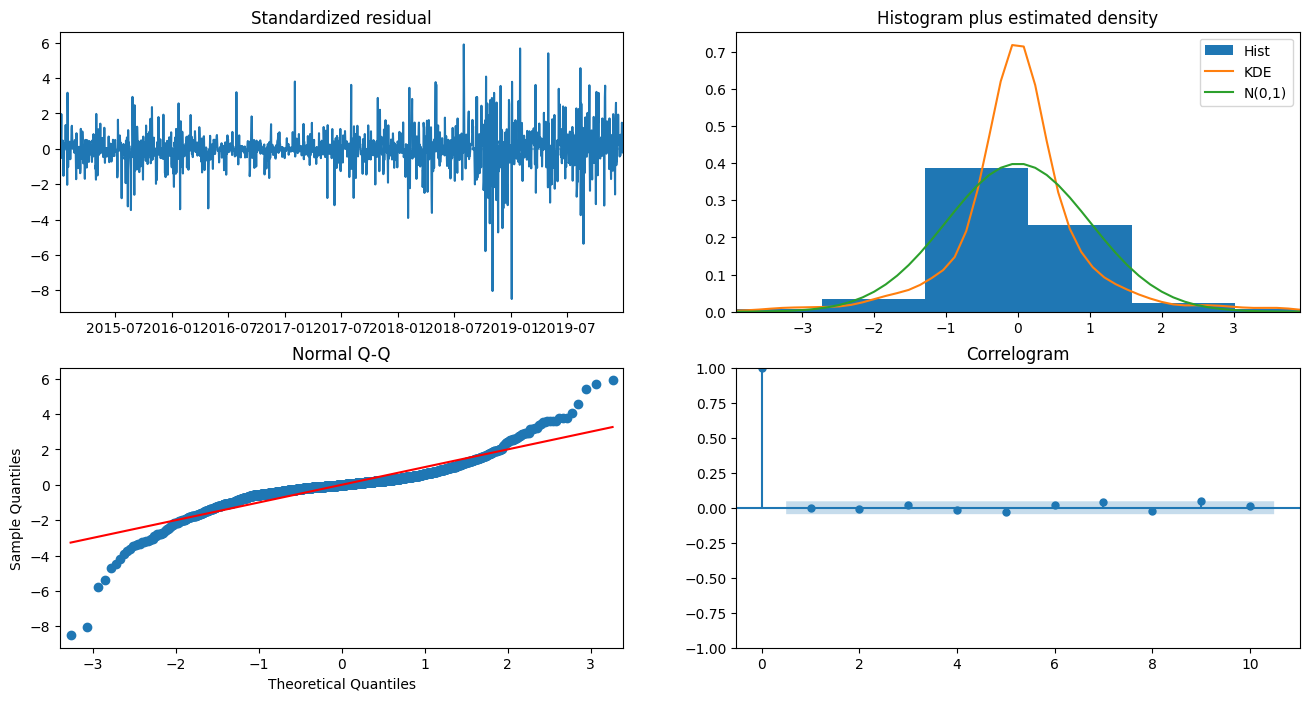

(0, 0, 1)


In [233]:
autoARIMA_model = pm.auto_arima(hist_data_diff,
                      seasonal=False,
                      trace=True,
                      suppress_warnings=True,
                      stepwise=True)
print(autoARIMA_model.summary())
autoARIMA_model.plot_diagnostics(figsize=(16,8))
plt.show()
bestmodel_order = autoARIMA_model.order
print(bestmodel_order)

In [234]:
# ARIMA order from ACF/PACF plot
manual_order = (1,0,1)

### Build ARIMA model

In [235]:
model = ARIMA(train_data, order=bestmodel_order)
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                 diff-1   No. Observations:                 1458
Model:                 ARIMA(0, 0, 1)   Log Likelihood                4960.571
Date:                Fri, 16 Aug 2024   AIC                          -9915.143
Time:                        16:15:28   BIC                          -9899.288
Sample:                    01-03-2015   HQIC                         -9909.228
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.767      0.443      -0.000       0.001
ma.L1          0.0932      0.018      5.099      0.000       0.057       0.129
sigma2      6.485e-05   9.82e-07     66.054      0.0

### Model predictions on test data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


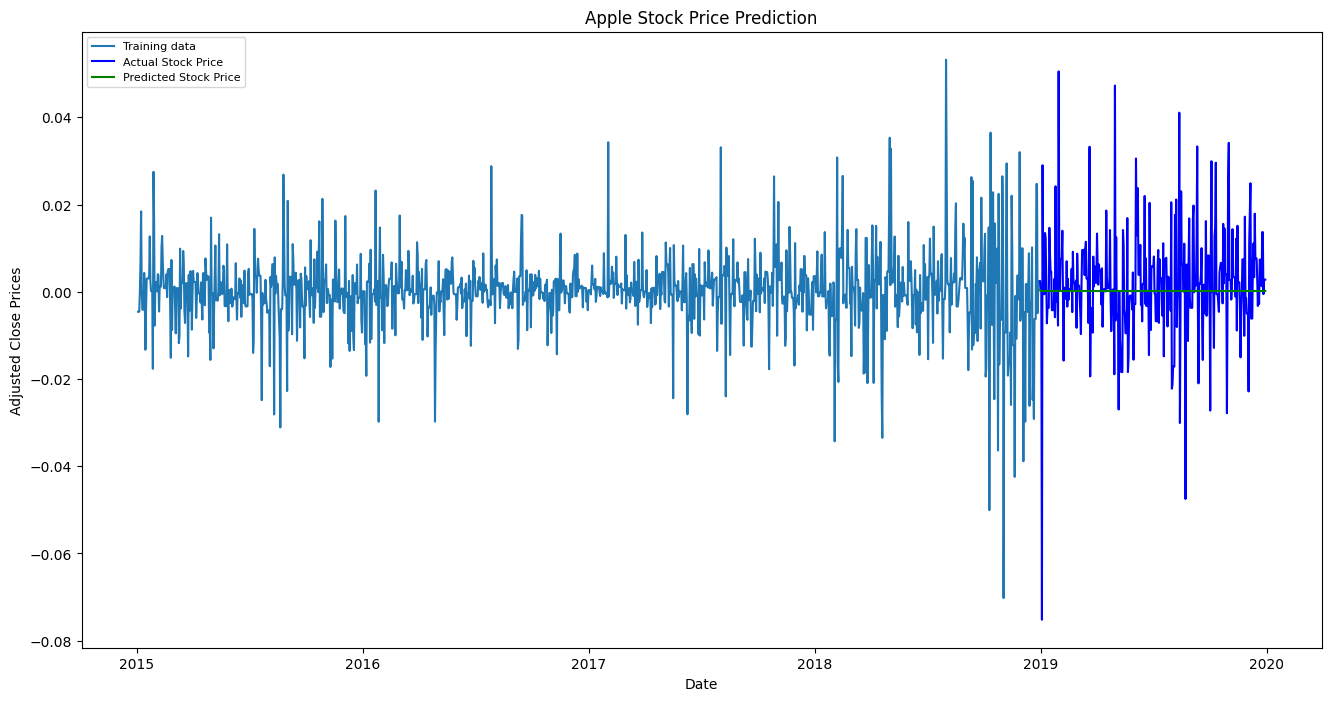

In [236]:
fc = fitted.forecast(steps=len(test_data), alpha=0.05)
fc1 = pd.Series(fc.values, index=test_data.index)
plt.figure(figsize=(16, 8))
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc1, color = 'green',label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Prices')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Residual Analysis

(array([5.50910334e-02, 5.50910334e-02, 2.20364134e-01, 9.91638602e-01,
        4.90310198e+00, 5.54215796e+01, 1.64722190e+01, 1.59763997e+00,
        5.50910334e-01, 5.50910334e-02]),
 array([-0.07163699, -0.05918721, -0.04673744, -0.03428766, -0.02183788,
        -0.00938811,  0.00306167,  0.01551145,  0.02796122,  0.040411  ,
         0.05286078]),
 <BarContainer object of 10 artists>)

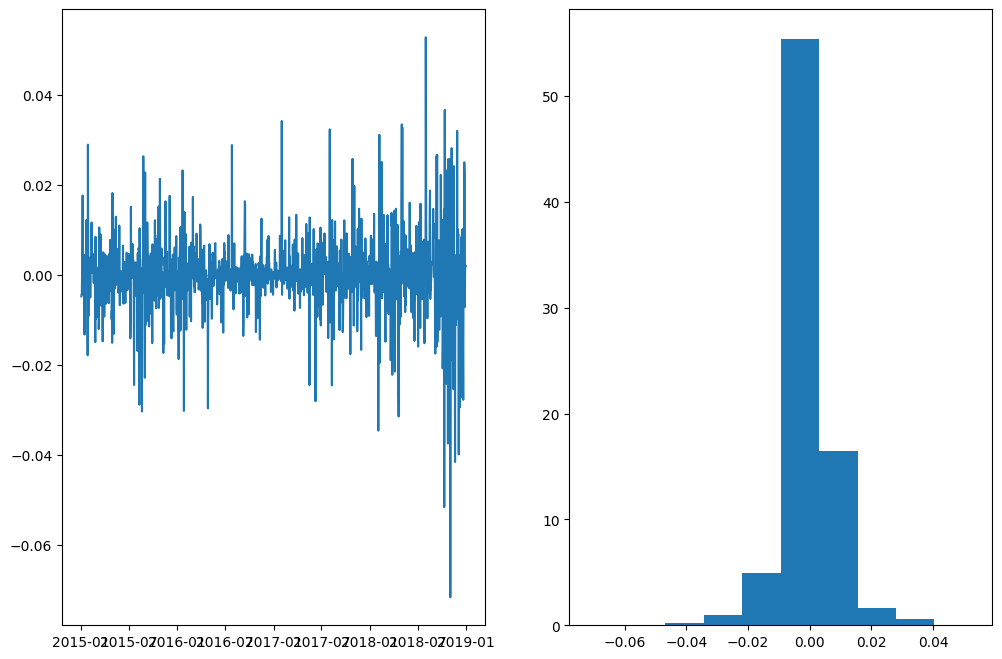

In [237]:
# Plot the residuals
residuals = pd.DataFrame(fitted.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.plot(residuals)
ax2.hist(residuals, density = True)

In [238]:
# Calculate the standard error of the residuals
residual = fitted.resid
stderr_residuals = round(np.std(residual),4)
print(f"Standard Error of Residuals: {stderr_residuals}")

Standard Error of Residuals: 0.0081


### Scaling Back to Original Value

In [239]:
# Convert differenced value to original value
last_value = hist_data['Adj Close Scaled'].iloc[len(train_data)]
fc_cumulative = last_value + np.cumsum(fc)
fc_series_scaled = pd.Series(fc_cumulative.values, index=test_data.index)
fc_series = scaler.inverse_transform(fc_series_scaled.values.reshape(-1, 1))
fc_series = pd.Series(fc_series.flatten(), index=test_data.index)

### Calculate Error Metrics

In [240]:
original_test_data = hist_data['Adj Close'][-len(test_data):]
mae = mean_absolute_error(original_test_data, fc_series)
print(f'MAE: {mae}')
mse = mean_squared_error(original_test_data, fc_series)
print(f'MSE: {mse}')
rmse = np.sqrt(mean_squared_error(original_test_data, fc_series))
print(f'RMSE: {rmse}')
def mean_absolute_percentage_error_manual(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_val = y_true != 0
    return np.mean(np.abs((y_true[non_zero_val] - y_pred[non_zero_val]) / y_true[non_zero_val])) * 100
mape_manual = mean_absolute_percentage_error_manual(original_test_data, fc_series)
print(f'MAPE (Manual): {mape_manual}')

MAE: 11.169247873607985
MSE: 180.78073555556105
RMSE: 13.445472678770392
MAPE (Manual): 20.48107325721319




### Visualisation

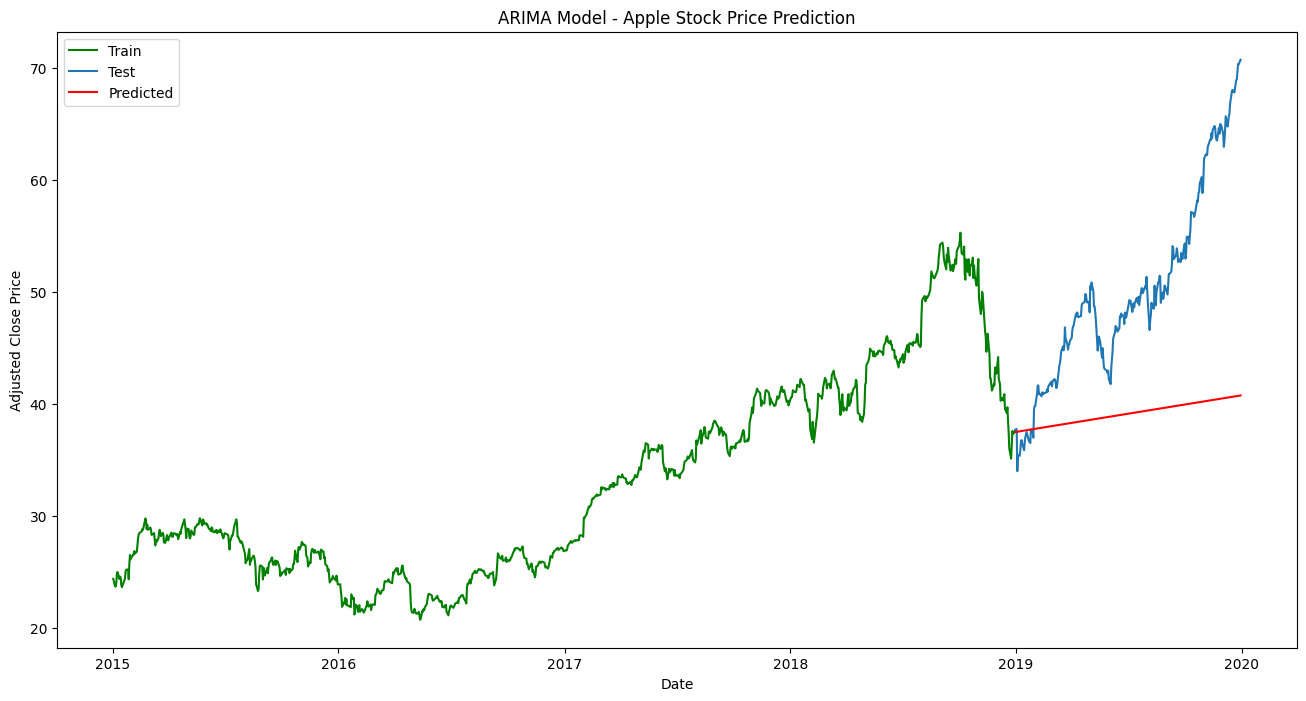

In [241]:
plt.figure(figsize=(16, 8))
plt.plot(hist_data['Adj Close'][:int(len(hist_data['Adj Close'])*0.8)], color='green', label='Train')
plt.plot(hist_data['Adj Close'][int(len(hist_data['Adj Close'])*0.8):], label='Test')
plt.plot(fc_series, color='red', label='Predicted')
plt.title('ARIMA Model - Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()